# Реализация универсальной состязательной атаки

Статья: https://arxiv.org/pdf/1610.08401

## Работа с датасетом, создание и обучение модели

In [1]:
# load data

import torch
import torchvision
import torchvision.transforms as transforms
import os

device = torch.device('cpu')
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    data_dir = os.path.join("./", 'fashion_mnist')
    print('Data stored in %s' % data_dir)
    trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
    testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)
    return trainloader,testloader



In [2]:
# model

import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Input = 1 * 28 * 28
        # Output = 16 * 28 * 28
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.batch1 = nn.BatchNorm2d(16)
        # Input = 16 * 28 *28
        # Output = 16 * 28 * 28
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        # Input = 16 * 28 * 28
        # Output = 16 * 28 *28
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.batch3 = nn.BatchNorm2d(16)
        # Input = 16 * 28 * 28
        # Output = 16 * 14 * 14
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Input = 16 * 14 * 14
        # Output = 32 * 14 * 14
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.batch4 = nn.BatchNorm2d(32)
        # Input = 32 * 14 * 14
        # Output = 32 * 14 * 14
        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.batch5 = nn.BatchNorm2d(32)
        # Input = 32 * 14 * 14
        # Output = 32 * 14 *14
        self.conv6 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.batch6 = nn.BatchNorm2d(32)
        # Input = 32 * 14 *14
        # Output = 32 * 7 * 7
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Input = 32 * 7 * 7
        # Output = 48 * 5 * 5
        self.conv7 = nn.Conv2d(32, 48, kernel_size=3)
        self.batch7 = nn.BatchNorm2d(48)

        # Input = 48 * 5 * 5
        # Output= 32 * 5 * 5
        self.conv8 = nn.Conv2d(48, 32, kernel_size=1)
        self.batch8 = nn.BatchNorm2d(32)

        # Input = 32 * 5 * 5
        # Output= 16 * 5 * 5
        self.conv9 = nn.Conv2d(32, 16, kernel_size=1)
        self.batch9 = nn.BatchNorm2d(16)

        self.pool3 = nn.AvgPool2d(5)

        self.fc1 = nn.Linear(1 * 1 * 16, 10)




    def forward(self,x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.batch3(x)
        x = F.relu(x)

        x = self.pool1(x)

        x = self.conv4(x)
        x = self.batch4(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = self.batch5(x)
        x = F.relu(x)

        x = self.conv6(x)
        x = self.batch6(x)
        x = F.relu(x)

        x = self.pool2(x)

        x = self.conv7(x)
        x = self.batch7(x)
        x = F.relu(x)

        x = self.conv8(x)
        x = self.batch8(x)
        x = F.relu(x)

        x = self.conv9(x)
        x = self.batch9(x)
        x = F.relu(x)

        x = self.pool3(x)

        x = x.reshape(-1, 16)
        x = self.fc1(x)
        return x

In [3]:
# train

import torch
from torch import nn
from torch import optim

class trainer:
    def __init__(self):
        self.net = ConvNet()
        self.net.to(device)

        self.criterion = nn.CrossEntropyLoss()

        self.optimizer = optim.Adam(self.net.parameters(), lr=0.01)
        self.n_epochs = 4

    def train(self, trainloader, testloader):
        accuracy = 0
        self.net.train()
        for epoch in range(self.n_epochs):
            running_loss = 0.0
            print_every = 200
            for i, (inputs, labels) in enumerate(trainloader, 0):

                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()

                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                if (i % print_every) == (print_every-1):
                    print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
                    running_loss = 0.0


            accuracy = compute_accuracy(self.net, testloader)
            print('Accuracy of the network on the test images: %d %%' % (100 * accuracy))

        print('Finished Training')
        return accuracy



def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [4]:
trainer = trainer()
trainset,testset  = load_data()
accuracy = trainer.train(trainset,testset)
trainset, testset = load_data()

Data stored in ./fashion_mnist
[1,   200] loss: 1.002
[1,   400] loss: 0.626
[1,   600] loss: 0.533
[1,   800] loss: 0.485
[1,  1000] loss: 0.439
[1,  1200] loss: 0.410
[1,  1400] loss: 0.391
[1,  1600] loss: 0.344
[1,  1800] loss: 0.334
Accuracy of the network on the test images: 87 %
[2,   200] loss: 0.655
[2,   400] loss: 0.450
[2,   600] loss: 0.372
[2,   800] loss: 0.360
[2,  1000] loss: 0.353
[2,  1200] loss: 0.355
[2,  1400] loss: 0.315
[2,  1600] loss: 0.313
[2,  1800] loss: 0.319
Accuracy of the network on the test images: 88 %
[3,   200] loss: 0.292
[3,   400] loss: 0.319
[3,   600] loss: 0.303
[3,   800] loss: 0.294
[3,  1000] loss: 0.306
[3,  1200] loss: 0.295
[3,  1400] loss: 0.301
[3,  1600] loss: 0.289
[3,  1800] loss: 0.298
Accuracy of the network on the test images: 90 %
[4,   200] loss: 0.281
[4,   400] loss: 0.268
[4,   600] loss: 0.287
[4,   800] loss: 0.287
[4,  1000] loss: 0.284
[4,  1200] loss: 0.277
[4,  1400] loss: 0.276
[4,  1600] loss: 0.282
[4,  1800] loss: 

In [5]:
import copy

import numpy as np
import torch as torch
from torch.autograd import Variable

# Реализация https://arxiv.org/pdf/1511.04599
def deepfool(image, net, num_classes, overshoot, max_iter):
    """
       :param image:
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """

    f_image = net.forward(Variable(
        image[None, :, :, :], requires_grad=True)).data.cpu().numpy().flatten()
    I = f_image.argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image[None, :], requires_grad=True)
    fs = net.forward(x)
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            x.grad.zero_()

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            if pert_k < pert:
                pert = pert_k
                w = w_k

        r_i = (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = Variable(pert_image, requires_grad=True)

        fs = net.forward(x.view(1, 1, image.shape[1], -1))
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    return (1+overshoot)*r_tot, loop_i


Описание основного алгоритма

![title](./Algo.png)

1. Инициализируем вектор возмущений нулями
2. Итерируемся в основном цикле, пока найти вектор, который будет менять прогноз у delta% картинок
3. Основной цикл
4. Пробегаем по всем картинкам, для каждоый вычисляем класс без изменений и с прибавленным вектором
5. Если класс поменялся переходим к следующей картинке
6. Если не поменялся, то алгоритмом deepfool находим минимальный вектор, который надо прибавить к возмущению, чтобы класс изменился
7. Если вектор найден, то осуществляем нормализацию нового вектора возмущения.
8. Считаем условие выхода из основного цикла, если пока недостаточно успешно атакованных картинок, переходим к шагу 3.

In [6]:
import numpy as np
from PIL import Image
import torch
from torchvision import transforms

def compute_universal_perturbation(
    accuracy, 
    trainset, 
    testset, 
    net, 
    delta=0.12, 
    max_iter_uni=np.inf, 
    num_classes=10, 
    overshoot=0.2, 
    max_iter_df=20):

    net.eval()
    device = 'cpu'

    img_trn = []
    for image in trainset:
        for image2 in image[0]:
            img_trn.append(image2.numpy())


    img_tst = []
    for image in testset:
        for image2 in image[0]:
            img_tst.append(image2.numpy())


    # Для подсчёта вектора возмущений достаточно взять часть изображений разных классов.
    # В статье говорится о том, что метод способен обобщать зависимости
    num_img_trn = 300
    index_order = np.arange(num_img_trn)
    
    transformer = transforms.ToTensor()
    transformer1 = transforms.Compose([
        transforms.ToTensor(),
    ])

    transformer2 = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(28),
    ])

    # Инициализируем вектор возмущений нулями(шаг 3 с картинки)
    v=np.zeros([28,28])
    
    
    # По fooling_rate вычисляем критерий остановки
    fooling_rate = 0.0
    iterations = 0

    fooling_rates=[0]
    accuracies = []
    accuracies.append(accuracy)
    total_iterations = [0]
    
    
    # Основной цикл алгоритма
    while fooling_rate < 1-delta and iterations < max_iter_uni:
        np.random.shuffle(index_order)
        
        # Перебираем весь датасет картинок(шаг 5 алгоритма)
        for index in index_order:
            v = v.reshape((v.shape[0], -1))

            # Получаем предсказание модели на картинке без изменений
            cur_img = Image.fromarray(img_trn[index][0])
            cur_img1 = transformer1(transformer2(cur_img))[np.newaxis, :].to(device)
            initial_class = (net(cur_img1).max(1)[1])
            torch.cuda.empty_cache()

            # Создаём возмущённую картинку (x + v)
            per_img = Image.fromarray(transformer2(cur_img)+v.astype(np.uint8))
            per_img1 = transformer1(transformer2(per_img))[np.newaxis, :].to(device)

            # Получаем предсказание на ней
            perturbation_class = (net(per_img1).max(1)[1])
            torch.cuda.empty_cache()

            # Если класс остался прежним(обмануть не получилось), то обновляем вектор-возмущение (шаг 6)
            if perturbation_class == initial_class:
                
                # Находим минимальное возмущение, которое позволит обмануть модель
                # Авторы статьи предлагают воспользоваться алгоритмом deepfool для этого - https://arxiv.org/pdf/1511.04599
                dr, iter_k = deepfool(per_img1[0], net, num_classes=num_classes, overshoot=overshoot, max_iter=max_iter_df)

                # Если был найден новый вектор(не упёрлись в ограничение по итерациям), то 
                # выполняем шаг 8
                if iter_k < max_iter_df-1:

                    v[:, :] += dr[0,0, :, :]
                    
                    # Считаем проекцию шаг 8 параметры xi = 2000 норма - l2
                    xi = 2000
                    v = v * min(1, xi / np.linalg.norm(v))
                    
        iterations = iterations + 1

        v = v.reshape((v.shape[0], -1, 1))

        # Подсчитываем результаты для текущего вектора
        with torch.no_grad():
            labels_original_images = torch.tensor(np.zeros(0, dtype=np.int64))
            labels_pertubed_images = torch.tensor(np.zeros(0, dtype=np.int64))

            i = 0
            # Классы для обычных картинок
            for batch_index, (inputs, _) in enumerate(testset):
                i += inputs.shape[0]
                inputs = inputs.to(device)
                outputs = net(inputs)
                _, predicted = outputs.max(1)
                labels_original_images = torch.cat((labels_original_images, predicted.cpu()))
            torch.cuda.empty_cache()
            correct = 0
            
            # Классы для изменённых картинок
            for batch_index, (inputs, labels) in enumerate(testset):
                inputs = inputs.to(device)
                inputs += transformer(v).float()
                outputs = net(inputs)
                _, predicted = outputs.max(1)
                labels_pertubed_images = torch.cat((labels_pertubed_images, predicted.cpu()))
                correct += (predicted == labels).sum().item()
            torch.cuda.empty_cache()


            # Определяем процент картинок, у которых класс поменялся
            fooling_rate = float(torch.sum(labels_original_images != labels_pertubed_images))/float(i)

            fooling_rates.append(fooling_rate)
            accuracies.append(correct / i)
            total_iterations.append(iterations)
            print(fooling_rate)
            print(accuracies[-1])
            print()
    return v, fooling_rates, accuracies, total_iterations


0.7795
0.215

0.8682
0.1298

0.8922
0.1096



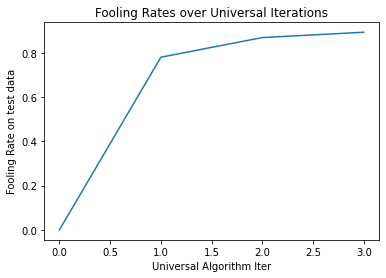

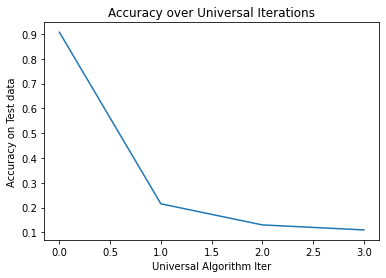

In [7]:
import matplotlib.pyplot as plt

v, fooling_rates, accuracies, total_iterations=compute_universal_perturbation(accuracy, trainset, testset, trainer.net)

plt.title("Fooling Rates over Universal Iterations")
plt.xlabel("Universal Algorithm Iter")
plt.ylabel("Fooling Rate on test data")
plt.plot(total_iterations, fooling_rates)
plt.show()


plt.title("Accuracy over Universal Iterations")
plt.xlabel("Universal Algorithm Iter")
plt.ylabel("Accuracy on Test data")
plt.plot(total_iterations, accuracies)
plt.show()